# Image Classification with MURA Dataset (Transfer Learning)
Classification is about assigning a label to an image from a given set of possible labels. Compared to segmentation and object detection, this task is the simplest.

In this Jupyter notebook, a pre-trained model will be re-trained with PyTorch using transfer learning, that can classify images of the MURA dataset into one of seven extremities classes.

## Dataset
The [MURA](https://stanfordmlgroup.github.io/competitions/mura/) (**mu**sculoskeletal **ra**diographs) dataset consists of 40,561 x-ray images of upper body extremities of the categories: Elbow, Finger, Forearm, Hand, Upper Arm, Shoulder, and Wrist. In addition, each image is assigned the label normal or abnormal.

<img src="https://stanfordmlgroup.github.io/competitions/mura/img/dataset.png" width="500"/>

Source: stanfordmlgroup.github.io


## Jupyter notebook
Jupyter notebooks are interactive Python scripts where Markdown and even Latex can be used for documentation. The purpose of this section is to provide general information such as keyboard shortcuts and common workflows, as well as information specific to this workshop and the hardware used when dealing with Python and Jupyter notebooks.

### Important things in a nutshell (a.k.a. TL;DR)
- **when switching to another notebook, always exit the kernel (Kernel -> Shutdown)**
- **Shift + Enter** to execute the active cell
- **Ctrl + Shift + p** to open the command palette (**Ctrl + Shift + f** in Firefox)
- **Shift + o** to toggle cell scrolling
- in case of error messages **restart the kernel (Kernel -> Restart)**
- "Help, I see the Markdown code" -> **Shift + Enter** in the corresponding cell
- "Help, I'm getting ResourceExhaustion / OutOfMemory (OOM) error" -> **Restart kernel, shutdown kernel from other still running notebooks** (click on the Jupyter logo in the upper left, then on the "Running" tab)
- "Help, my notebook is broken" -> see **Notebook "Recovery "**.
- " Is something happening?" -> if the **circle at the top right of "Python 3" is filled and dark** then the kernel is still working, if it is not filled then the kernel is idle. The currently running cell is the first one seen from the top, where "In[*]" is written on the left side instead of e.g. "In[5]". But it can happen that the kernel freezes, in this case just click on __Kernel -> Interrupt__ and execute the cell again.


### Overview & Workflow
The only two shortcuts you really have to remember are
- **Shift + Enter** to execute a cell, and
- **Ctrl + Shift + p** to open the command palette, from which you then have direct access to all possible commands, including the corresponding shortcuts.

Another useful shortcut is **Shift + o**, which toggles **Scrolling for cell output**.

To **edit a cell** it is sufficient to double-click inside the cell, for code cells it is sufficient to simply click outside the cell to exit edit mode, for documentation cells (like this one) it is necessary to execute the cell to exit code view.

While a cell is executing, the kernel indicator in the upper right corner next to "Python 3" changes from a light circle with a dark border to a filled dark circle and jumps back as soon as the execution is finished. If multiple cells were executed at the same time, the label in the left column tells you whether the cell has finished executing (**In [NUMBER]:**) or is currently executing or waiting to execute (**In [*]:**). Additionally, after a cell has been executed, the cell output is displayed below the cell.

To keep the overview it can sometimes be useful to delete the **cell output**. This can be done in these two ways, among others:
- top of Cell -> Current Outputs / All outputs -> Clear
- on top of Kernel -> Restart & Clear Output

The kernel is responsible for the execution of the Python code and keeps the context (i.e. used variables, defined functions and used memory) available since the last kernel (re)start. This can lead to problems if cells are executed in a different order or if cells are skipped in which variables or functions are defined that are needed in the further course of the script, but also if **an other Jupyter notebook is started**, since another kernel is started for this.

Therefore when **changing to another notebook** always shutdown or restart the **kernel** (above Kernel -> Restart/Shutdown).

# 1. Imports and Setup
The first step is to install and import the required Python packages. If the required packages have not yet been installed, this can be done in the shell e.g. via `pip install <package-name>`. This example was tested with the following packages: [Numpy 1.24.4](https://numpy.org/), [Pandas 1.4.1](https://pandas.pydata.org/), [Matplotlib 3.5.1](https://matplotlib.org/), [PyTorch 1.11.0](https://pytorch.org/), [Torchvision 0.12.0](https://pytorch.org/vision/stable/index.html), [PyTorch Image Models 0.9.7](https://github.com/rwightman/pytorch-image-models), [torchinfo 1.8.0](https://github.com/TylerYep/torchinfo), [TorchMetrics 1.3.1](https://torchmetrics.readthedocs.io/en/stable/), [pkbar 0.5](https://github.com/yueyericardo/pkbar), [opencv-python-headless 4.9.0.80](https://opencv.org/)

Unlike Tensorflow, PyTorch only ever reserves as much GPU VRAM (graphics memory) as is needed to run the code. Several factors affect the amount of graphics memory required when training a neural network, e.g., the number of parameters (weights) of the neural network, the minibatch size (discussed in more detail later in the script), the number of subprocesses (workers) when loading data, etc. However, with `torch.cuda.set_per_process_memory_fraction(fraction: float)`, PyTorch can be instructed to use only a maximum fraction of the available graphics memory for code execution, for example, to run multiple training processes simultaneously on one GPU.

In [1]:
import os, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

from timm.models import create_model
from torchinfo import summary
from torchmetrics import MeanMetric, Accuracy, F1Score, Precision, Recall, ConfusionMatrix
import pkbar, tqdm

# Limit the amount of available GPU-VRAM for code execution
#torch.cuda.set_per_process_memory_fraction(0.5)
torch.cuda.empty_cache()

# enable cudnn auto-tuner to find the best algorithms for the underlying hardware
torch.backends.cudnn.benchmark = True
torch.manual_seed(42) # set seed for reproducible results

## 1.1 Folder Structure
For this example the following directories should be created:
- `ROOT_DIR`: The main directory where the Jupyter notebook is located (`os.getcwd()` is helpful here)
- `MODEL_DIR`: Directory where trained models should be stored
- `DATA_DIR`: directory where the dataset is located

In [2]:
ROOT_DIR = os.path.abspath(os.getcwd()) # current path of the notebook
MODEL_DIR = os.path.join(ROOT_DIR, "models/classification_transferlearning")
DATA_DIR = "/raid/datashare/MURA-v1.1"

print("Directories:")
print("Root directory:", ROOT_DIR)
print("Model directory:", MODEL_DIR)
print("Datasets directory:", DATA_DIR)

Directories:
Root directory: /home/simon.puettmann/classification
Model directory: /home/simon.puettmann/classification/models/classification_transferlearning
Datasets directory: /raid/datashare/MURA-v1.1


Here the folder structure can be examined with simple Linux commands

In [3]:
!ls -l $DATA_DIR
!ls -l $DATA_DIR/train
!ls -l $ROOT_DIR

total 3416
drwxrwxr-x 9 rueckert rueckert    4096 May 27  2019 train
-rwxrwxr-x 1 rueckert rueckert 2423416 May 27  2019 train_image_paths.csv
-rwxrwxr-x 1 rueckert rueckert  778367 May 27  2019 train_labeled_studies.csv
drwxrwxr-x 9 rueckert rueckert    4096 May 27  2019 valid
-rwxrwxr-x 1 rueckert rueckert  210674 May 27  2019 valid_image_paths.csv
-rwxrwxr-x 1 rueckert rueckert   69469 May 27  2019 valid_labeled_studies.csv
total 384
drwxrwxr-x 1713 rueckert rueckert 57344 May 27  2019 XR_ELBOW
drwxrwxr-x 1867 rueckert rueckert 57344 May 27  2019 XR_FINGER
drwxrwxr-x  867 rueckert rueckert 32768 May 27  2019 XR_FOREARM
drwxrwxr-x 1947 rueckert rueckert 65536 May 27  2019 XR_HAND
drwxrwxr-x  589 rueckert rueckert 20480 May 27  2019 XR_HUMERUS
drwxrwxr-x 2696 rueckert rueckert 69632 May 27  2019 XR_SHOULDER
drwxrwxr-x 3269 rueckert rueckert 90112 May 27  2019 XR_WRIST
total 7388
-rw-r--r-- 1 simon.puettmann simon.puettmann 2511370 May 27 10:43 01_classification_fromscratch.ipynb
-rw-r

# 2. Dataset
Here we define the dataset. There are many different ways to read data in PyTorch, in this example we first define a dataset object with [ImageFolder](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html) which reads and preprocesses image data using the folder structure `/path/to/dataset/split/class/image.png`. Preprocessing steps as well as transformation options for data augmentation can be chained together in PyTorch in the form of a preprocessing pipeline `transforms.Compose` and passed to the dataset as `transform` parameters. Details of the transformation and preprocessing steps can be found at the link [Transforming and augmenting images](https://pytorch.org/vision/stable/transforms.html) and used later for optimization.

In our example the name of the dataset folder is `MURA-v1.1` and the possible __splits__ are `train` and `valid`, the classes correspond to the folder names inside the subdirectories `train/` as well as `valid/`. `ImageFolder` automatically maps the corresponding images in the subdirectories to the classes and creates class labels 0-N.

ImageFolder reads the image data and the corresponding labels one by one and makes them available via the function `__getitem__(index: int)`. When training a model, we usually want to process multiple images in the form of "minibatches", re-sort the image data at each training epoch, and use multiprocessing to load the image data in parallel. In PyTorch, these functions are available using the `DataLoader`, which creates a "minibatch iterable" from the dataset object. An important variable here is `BATCH_SIZE`, which determines how many images are loaded into a minibatch. If you choose this value too high, the reserved graphics memory will not be sufficient, if you choose it too low, the training will be very slow. For our example this value should be set to 32. With the `SubsetRandomSampler` we instruct the `DataLoader` to use only 50% of the training data for training to speed up the training times for testing purposes. For the final training, the `SubsetRandomSampler` should be removed to train with the entire training dataset.

In [4]:
# Dataset directory
TRAIN_DATA_DIR = DATA_DIR + '/train/'
VALID_DATA_DIR = DATA_DIR + '/valid/'

BATCH_SIZE = 16
IMAGE_SIZE = 224 
PRE_CROPPED_SIZE = 256 

# Train data pre-processing and data augmentation pipeline
train_transforms = transforms.Compose([
                        # data augmentation
                        transforms.Resize((PRE_CROPPED_SIZE, PRE_CROPPED_SIZE)), # pre-crop image to PRE_CROPPED_SIZE
                        transforms.RandomCrop((IMAGE_SIZE, IMAGE_SIZE)), # randomly crop a region of IMAGE_SIZE from the pre-cropped image
                        transforms.RandomHorizontalFlip(p=0.5), # randomly flip image horizontally
                        transforms.RandomAffine(degrees=20, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=10), # randomly rotate (degrees), translate, scale, shear image 
                        
                        # pre-processing: normalize image pixel values to [-1,1]
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])

# Valid data pre-processing pipeline
valid_transforms = transforms.Compose([
                        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])

print("Start preparing dataset... please wait, this may take a while")

# ImageFolder will read images found in subfolers of '/train' and creates mini batches using the DataLoader
train_dataset = ImageFolder(root=TRAIN_DATA_DIR, transform=train_transforms)
train_loader = DataLoader(dataset=train_dataset, 
                          shuffle=False, # shuffling is done by sampler 
                          batch_size=BATCH_SIZE, 
                          num_workers=4, # for multiprocessing
                          # Use a subset (50%) of the training images for faster training (should be removed for final training)
                          sampler=SubsetRandomSampler(torch.randint(high=len(train_dataset), size=(int(len(train_dataset)*0.5),))),
                          pin_memory=True)
print(f'Found {len(train_dataset.samples)} training images belonging to {len(train_dataset.classes)} classes: {train_dataset.classes}')

# ImageFolder will read images found in subfolers of '/valid' and creates mini batches using the DataLoader
valid_dataset = ImageFolder(root=VALID_DATA_DIR, transform=valid_transforms)
valid_loader = DataLoader(dataset=valid_dataset, 
                          shuffle=False, 
                          batch_size=BATCH_SIZE, 
                          num_workers=4, # for multiprocessing
                          pin_memory=True)
print(f'Found {len(valid_dataset.samples)} validation images belonging to {len(valid_dataset.classes)} classes: {valid_dataset.classes}')
print("Dataset prepared")

# make sure these numbers are correct, you can count images using something like
# find path/to/dataset/split -name ".png" | wc -l
# or you just run the script above once and look for the
# "Found X images belonging to Y classes." lines
NUM_TRAINING_SAMPLES = 36808
NUM_VALIDATION_SAMPLES = 3197
CLASSES = ['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']
NUM_CLASSES = len(CLASSES)

Start preparing dataset... please wait, this may take a while
Found 36808 training images belonging to 7 classes: ['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']
Found 3197 validation images belonging to 7 classes: ['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']
Dataset prepared


## 2.1 Display images
The following will extract a minibatch from the training dataset. To display images from the validation dataset instead, simply change the `train_loader` to `valid_loader`.

This block can be executed any number of times, the minibatch will be selected randomly each time. The images from the training dataset are augmented.

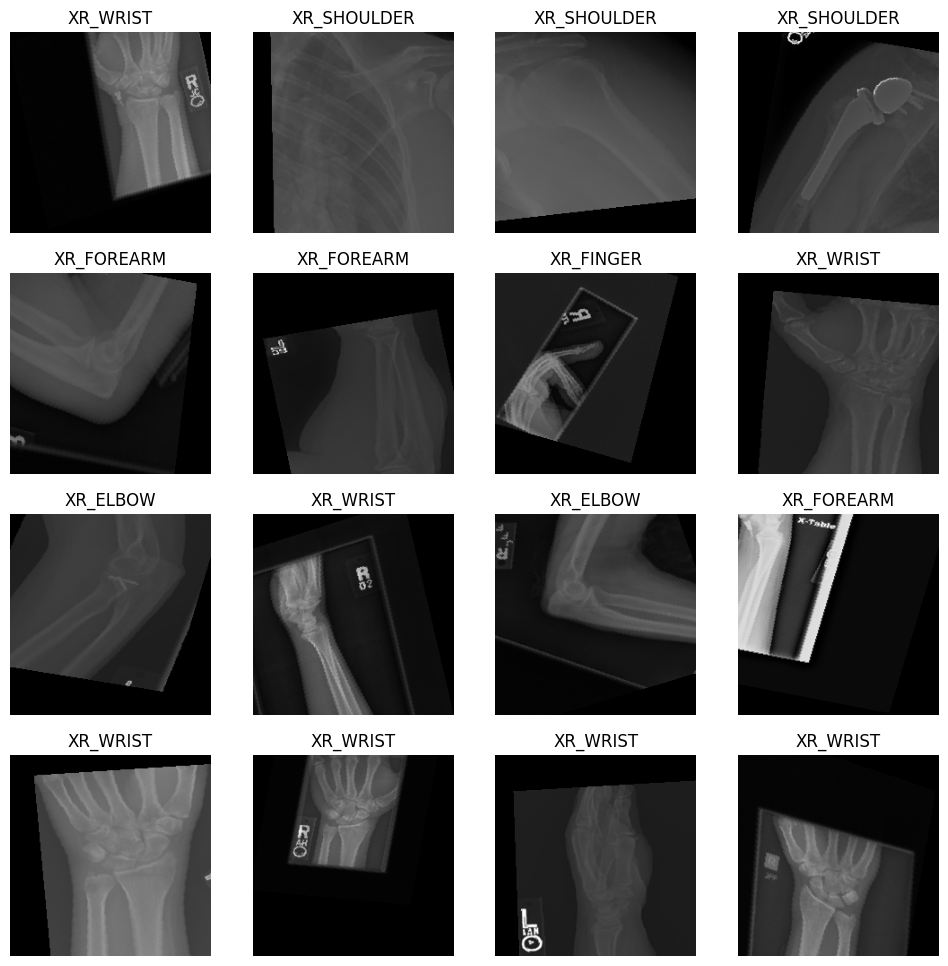

In [5]:
def denormalization(img, mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)):
    # denormalize pixel values of [-1,1] to [0,1] 
    img = img * std + mean 
    return img

def show_batch(images, labels):
    images = images.numpy() 
    labels = labels.numpy()
    
    fig, ax = plt.subplots(4, 4, figsize=(12,12))
    for i, ax in enumerate(ax.flat):
        ax.imshow(denormalization(np.rollaxis(images[i,:,:,:],0,3)), vmin=0, vmax=1, cmap='gray') # np.rollaxis(images[i,:,:,:],0,3)) to swap channel axes to channels last
        ax.set_title(CLASSES[labels[i]])
        ax.axis('off')
    plt.show()

dataiter = iter(train_loader) # get iterator of train_loader 
images, labels = next(dataiter) # get a random batch of train_loader iterator
show_batch(images, labels) # show images of batch 

# 3. Retrain a pre-trained Model (Transfer-Learning)

In practice, it is rare to retrain a complete Convolutional Network from scratch (with random initialization of model weights), as often there are not large enough datasets available. Instead, it is common to pre-train a CNN on very large datasets (e.g. ImageNet with 1.2 million images from 1000 classes) and then use the pre-trained CNN as initialization or feature extractor.

More details on transfer learning at: https://cs231n.github.io/transfer-learning/

<a id='from_scratch'></a>

## 3.1 Creating the Model
Next, the model is created. The variable `MODEL_DIR` specifies the directory where checkpoints of the trained model weights will be stored and can be loaded via the variable `MODEL_CHECKPOINTS` when training should be resumed.

The `create_model()` function can be used to load base models for image classification from the GitHub repository [PyTorch Image Models](https://github.com/rwightman/pytorch-image-models). In this case a ResNet50, other models can be specified with the `model_name` parameter. A list of all models is available in the GitHub repository. To use a pre-trained model, the `pretrained` parameter must be set to `True` when the base model is created with the `create_model()` function. The number of nodes in the output layer of the base model classifier can be changed using the `num_classes` parameter and should correspond to the number of classes in the dataset. 

The `torchinfo` package and the `summary()` function can be used to clearly display the structure of the base model. Alternatively, this can also be done with the Python function `print()`.

In [6]:
print("Creating model")
print("model_dir: ", os.path.realpath(MODEL_DIR))
os.makedirs(MODEL_DIR, exist_ok=True)

# Create model
# see https://github.com/rwightman/pytorch-image-models
model = create_model(model_name="resnet50", 
                     pretrained = True, # use imagenet pre-trained model 
                     num_classes = NUM_CLASSES)

MODEL_CHECKPOINTS = None # Specifying model checkpoints for continuing training, e.g. f"{MODEL_DIR}model_epoch1.pth"
if MODEL_CHECKPOINTS: # load model checkpoints if available
    model.load_state_dict(torch.load(MODEL_CHECKPOINTS, map_location="cpu"))

print(summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE)))
print(model)

print("Model successfully created")

Creating model
model_dir:  /home/simon.puettmann/classification/models/classification_transferlearning
Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [16, 7]                   --
├─Conv2d: 1-1                            [16, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [16, 64, 112, 112]        128
├─ReLU: 1-3                              [16, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [16, 64, 56, 56]          --
├─Sequential: 1-5                        [16, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [16, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [16, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [16, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [16, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [16, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5            

### Transfer Learning Strategy
Different strategies are possible for transfer learning of a pre-trained model. The following are the two most important ones:
- Using the CNN as a feature extractor: In this strategy, only the classifier (the last fully-connected layer(s) of the model) is replaced as well as re-trained. The previous layers of the CNN are used as a feature extractor for the new dataset and are frozen during the training process, so no adjustment of the model weights is done.
- Fine-tuning the CNN: the second strategy is not only to replace the classifier of the CNN and re-train it on a new dataset, but also to fine-tune (re-train) the model weights in the previously trained layers of the CNN. It is possible to fine-tune all layers of the CNN or to fine-tune only part of the model of the deeper layers, keeping some of the previous layers and freezing them during re-training. If randomly initialized layers of the replaced classifier are mixed with pre-trained layers of the CNN, there is a risk that during the first training epochs very large gradient updates will destroy the optimized model weights in the earlier pre-trained layers of the CNN. Therefore, it may be advisable to retrain the classifier first in a few training epochs, and then all layers afterwards. 

__Task:__ Experiment with different transfer learning strategies, freeze different numbers of model layers and compare the effects. Also try to retrain all layers of the model.

#### Freezing Model Parameters
The following script displays all learnable parameters of the model that can be optimized during the training process. To freeze the model parameters and prevent optimization during training, the parameter attribute `requires_grad` must be set to `False`. The variable `freeze_params_idx` contains a list of all parameter indices of the model whose parameters should be frozen for the training process.

__Notes:__ The parameters for the model classifier are located at the end of the model. If the parameter states are changed, all subsequent cells (especially those of the optimizer) must be executed again.

In [7]:
freeze_params_idx = np.arange(72).tolist() # specify the parameter indices of the model that should be freezed

# freeze or unfreeze learnable parameters of model architecture
for i, (param_name, param) in enumerate(model.named_parameters()):
    if i in freeze_params_idx: # freeze parameter weights if parameter_idx in freeze_params_idx
        param.requires_grad = False
        print(f'{i} {param_name} -> freezed')
    else:
        param.requires_grad = True # unfreeze parameter weights if parameter_idx not in freeze_params_idx
        print(f'{i} {param_name} -> unfreezed')

0 conv1.weight -> freezed
1 bn1.weight -> freezed
2 bn1.bias -> freezed
3 layer1.0.conv1.weight -> freezed
4 layer1.0.bn1.weight -> freezed
5 layer1.0.bn1.bias -> freezed
6 layer1.0.conv2.weight -> freezed
7 layer1.0.bn2.weight -> freezed
8 layer1.0.bn2.bias -> freezed
9 layer1.0.conv3.weight -> freezed
10 layer1.0.bn3.weight -> freezed
11 layer1.0.bn3.bias -> freezed
12 layer1.0.downsample.0.weight -> freezed
13 layer1.0.downsample.1.weight -> freezed
14 layer1.0.downsample.1.bias -> freezed
15 layer1.1.conv1.weight -> freezed
16 layer1.1.bn1.weight -> freezed
17 layer1.1.bn1.bias -> freezed
18 layer1.1.conv2.weight -> freezed
19 layer1.1.bn2.weight -> freezed
20 layer1.1.bn2.bias -> freezed
21 layer1.1.conv3.weight -> freezed
22 layer1.1.bn3.weight -> freezed
23 layer1.1.bn3.bias -> freezed
24 layer1.2.conv1.weight -> freezed
25 layer1.2.bn1.weight -> freezed
26 layer1.2.bn1.bias -> freezed
27 layer1.2.conv2.weight -> freezed
28 layer1.2.bn2.weight -> freezed
29 layer1.2.bn2.bias -> 

### Loss Function
Machine learning is basically an optimization task that aims to minimize an error between predictions of a model e.g. a neural network and actual observations from a dataset. To quantify the error between model predictions and actual observations, a loss function is required. If the model predictions deviate too much from the actual observations, the loss function takes on a very high value, the so-called loss. The goal of the training process is now to minimize this loss step by step by adjusting the weights of the neural network using optimization algorithms.

PyTorch has already implemented many different [loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions).
One loss function commonly used for classification tasks is [cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss), which we will also use in this example.

In [8]:
# Loss function
loss_function = torch.nn.CrossEntropyLoss() 

### Optimizer
Optimizers are optimization algorithms and are responsible for adjusting weights in the training process. PyTorch already implements a number of different [optimizers](https://pytorch.org/docs/stable/optim.html#module-torch.optim) with different optimization methods. We will use the [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) optimizer for our training. The `filter(lambda param: param.requires_grad, model.parameters())` statement passes only those model parameters to the optimizer for optimization that were not frozen in the previous step.

An important parameter of the optimizers is the learning rate, which can be used to adjust the amount of weight adjustment per training step. Common learning rates range from `0.001` to `0.00001`. Larger learning rates allow faster training, but can also lead to problematic jumps in solution space and divergence (consistently bad errors). Smaller learning rates are suitable for fine-tuning.

__Task:__ Replace the variable `LEARN_RATE` with a suitable learning rate. Experiment with different learning rates.

In [9]:
# optimizer 
LEARN_RATE = 5e-05
optimizer = torch.optim.Adam(filter(lambda param: param.requires_grad, model.parameters()), lr=LEARN_RATE)

### Learning Rate Scheduler
Learning rate adjustments (often called learning rate schedulers) can be used to dynamically adjust the learning rate during training. A common strategy is to start with high learning rates to quickly get close to a local minimum, and then use lower learning rates to get as close as possible to that local minimum. PyTorch already implements a variety of different [learning rate adaptation strategies](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate).  

For the training in this example, let's try different learning rate adaptation strategies:
- [StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html#torch.optim.lr_scheduler.StepLR): Learning rate adjustments after fixed number of epochs.
- [CosineAnnealingLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html#torch.optim.lr_scheduler.CosineAnnealingLR): Learning rate adjustments along a cosine cycle.
- [LambdaLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.LambdaLR.html#torch.optim.lr_scheduler.LambdaLR): independent implementation of a learning rate adjustment strategy for exponential learning rate adjustments `LR_EXPDECAY`.

\begin{equation*}
lr = lr_{init} \cdot e^{-d \cdot i}
\end{equation*}
where $lr$ = learning rate, $lr_{init}$ = initial learning rate, $d$ = decay, $i$ = training epoch. 

Some of the LR schedulers implemented in PyTorch require the maximum number of training iterations/epochs for initialization. We specify this using the variable `NUM_EPOCHS`. 

__Task:__ Experiment with different strategies for learning rate adaptation.

In [10]:
# max. number of training epochs
NUM_EPOCHS = 20

# lr scheduler strategies (decomment the LR scheduler you want to use)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, gamma=0.5, last_epoch=-1) # lr scheduler step strategy 
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, NUM_EPOCHS, eta_min=1e-05, last_epoch=-1) # learning rate scheduler with cosine annealing strategy
# LR_EXPDECAY = lambda epoch: math.exp(-0.5*epoch) # exponential decay strategy
# lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, LR_EXPDECAY) # learning rate scheduler with exponential decay

### Visualization of the Learning Rate Scheduler
To visualize the effects of each learning rate adaptation strategy on learning rate over the course of the training epochs, the following script can be used. LR schedulers that are not to be tested must be commented out in the script.

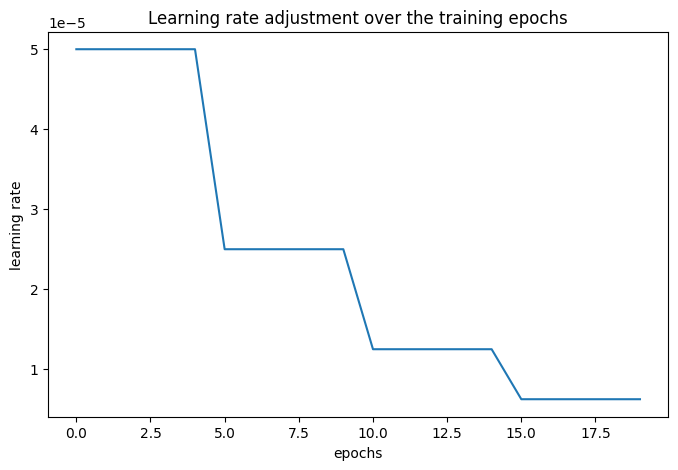

In [11]:
# this optimizer is only used for visualization
optimizer_vis = torch.optim.Adam(model.parameters(), lr=LEARN_RATE) 

# this lr scheduler is only used for visualization (decomment a LR scheduler for visualization purposes)
lr_scheduler_vis = torch.optim.lr_scheduler.StepLR(optimizer_vis, 5, gamma=0.5, last_epoch=-1) # lr scheduler with cosine annealing strategy 
#lr_scheduler_vis = torch.optim.lr_scheduler.LambdaLR(optimizer_vis, LR_EXPDECAY) # lr scheduler with previous defined LR_DECAY strategy
#lr_scheduler_vis = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_vis, NUM_EPOCHS, eta_min=1e-05, last_epoch=-1) # lr scheduler with step strategy

learning_rates = []
for i in range(NUM_EPOCHS):
    optimizer_vis.step()
    lr = optimizer_vis.param_groups[0]["lr"] # get current learning rate of optimizer
    learning_rates.append(lr)
    lr_scheduler_vis.step()

# plot graph
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.plot(np.arange(NUM_EPOCHS), learning_rates)
ax.set_xlabel('epochs')
ax.set_ylabel('learning rate')
ax.set_title('Learning rate adjustment over the training epochs')
plt.show()

### Metrics and logs for monitoring the training progress.

In addition to loss, other [metrics](https://de.wikipedia.org/wiki/Beurteilung_eines_bin%C3%A4ren_Klassifikators) can be helpful in evaluating the training progress of a neural network. Often, the proportion of correctly classified training examples is also determined, the so-called classification accuracy. Important! While the loss in the training process is mandatory as a measurement for the optimization of the network weights, the classification accuracy is only used to monitor the training progress and is therefore optional. The package [TorchMetric](https://torchmetrics.readthedocs.io/en/stable/) provides a convenient solution to collect different metrics during the training process.

For later visualization of the training process it is useful to log losses and other metrics during the training. In this example, these are stored in the dictonary `logs` during the training. 

In [12]:
loss_metric = MeanMetric()
accuracy_metric = Accuracy(task="multiclass", num_classes=NUM_CLASSES)

logs = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

## 3.2 Model Training

In order for PyTorch to perform training on the GPU, all the important components of the training process, such as the model itself, the loss function, metrics, images and labels from the DataLoader, etc., must be moved to the VRAM of the GPU. This is possible via the function `.to(device)`. `device` is a variable that takes the string "cuda" if a GPU is available, otherwise the string "cpu" and the training does not take place on a GPU.

In [13]:
device = ("cuda" if torch.cuda.is_available() else "cpu") 

# move model, loss and metrics to GPU-VRAM if available
model = model.to(device, non_blocking=True)
loss_function = loss_function.to(device)
loss_metric = loss_metric.to(device)
accuracy_metric = accuracy_metric.to(device)

#scaler for automatic mixed precision
scaler = torch.cuda.amp.GradScaler(enabled=True)

The actual training takes place subsequently and can take some time. Whether the kernel is still active in the background can be seen by the circle in the upper right corner - as long as the circle is filled, the script is still running.

The training is done epoch by epoch `for epoch in range(NUM_EPOCHS):`, where one training epoch corresponds to the pass of all minibatches of the training dataset. The variable `NUM_EPOCHS` (defined above) can be used to specify the number of training epochs.

A training epoch now consists of two phases, the training phase and the validation phase. At the beginning of a training phase the model is first put into training mode `model.train()` and previously stored metrics are reset `loss_metric.reset()`. Then we iterate over the minibatches of the training dataset `for i, (images, labels) in enumerate(train_loader, 0)`, move the images and labels of the minibatch into the GPU VRAM `images.to(device) ...`, delete previously stored gradient information of the optimizer `optimizer. zero_grad()`, pass the image data of the minibatch to the model for prediction `outputs = model(images)`, determine the loss between models prediction and labels (ground truths of the images) of the minibatch `loss = loss_function(outputs, labels)`, backpropagate the loss over the model weights (gradient information is determined) `loss.backward()`, adjust the model weights with the optimizer according to the gradient information `optimizer.step()` and determine metrics for this training step `... accuracy_of_batch = accuracy_metric(predictions, labels)`.

When all minibatches in the training dataset have been passed, a training epoch is complete. After the training epoch, the learning rate scheduler `lr_scheduler.step()` is called, which adjusts the learning rate according to the defined strategy for the next training epoch, and the averaged loss `loss_metric.compute() ...` and the averaged metrics for the entire training epoch are computed and stored in `logs`.

Following the training phase, the validation phase begins. In the validation phase, loss and metrics are determined using `unseen` validation data. Important. There is no adjustment of model weights. The validation phase differs only slightly from the previously described training phase. First, the model is put into `model.eval()` validation mode, the metrics from the previous training phase are reset and then we iterate over all the minibatches in the validation dataset, pass the image data to the model for prediction, determine loss and metrics and finally store them in `logs`. 

At the end of each training epoch, the model weights of the current epoch are `torch.save(model.state_dict(), ...)` stored and the computed training/validation loss and metrics are saved to a CSV file.

In [14]:
from codecarbon import EmissionsTracker

NUM_EPOCHS = 20 # NUM_EPOCHS was defined earlier 

print("Start training pretrained model")
tracker = EmissionsTracker(measure_power_secs=9999)
tracker.start()

try:
    #iterate over epochs
    for epoch in range(NUM_EPOCHS):
        
        # progress bar [optional]
        kbar = pkbar.Kbar(target=len(train_loader), epoch=epoch, num_epochs=NUM_EPOCHS, width=24, always_stateful=False)
        
        ############################## training phase ####################################
        # set model to training phase
        model.train()
        
        # reset metrics for training phase
        loss_metric.reset()
        accuracy_metric.reset()
        
        # iterate over training batches 
        for i, (images, labels) in enumerate(train_loader, 0):
            # move training batch with labels to GPU-VRAM 
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
    
            # zero the parameter gradients
            optimizer.zero_grad(set_to_none=True)
    
            # forward pass with mixed precision
            with torch.autocast(device_type=device, dtype=torch.float16, enabled=True):
                outputs = model(images)
                loss = loss_function(outputs, labels)
            
            # backward pass 
            #loss.backward()
            #optimizer.step()

            # scaled backward pass
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            # update running metrics
            predictions = outputs.softmax(dim=-1)
            loss_of_batch = loss_metric(loss)
            accuracy_of_batch = accuracy_metric(predictions, labels)
            
            # Update progress bar [optional]
            kbar.update(i, values=[("loss", loss_of_batch), ("accuracy", accuracy_of_batch)])
        
        # learning rate scheduler step 
        lr_scheduler.step()
        
        # calculate training metric results for the epoch and append results to logs
        epoch_loss = loss_metric.compute().detach().cpu().item()
        epoch_accuracy = accuracy_metric.compute().detach().cpu().item()
        logs['loss'].append(epoch_loss)
        logs['accuracy'].append(epoch_accuracy)
            
              
        ############################## validation phase ####################################
        # set model to validation phase
        model.eval()
        
        # reset metrics for validation phase
        loss_metric.reset()
        accuracy_metric.reset()
        
        # prevents PyTorch from gathering gradients to speed up validation phase
        with torch.no_grad():
            # iterate over validation batches 
            for i, (images, labels) in enumerate(valid_loader, 0):
                # move validation batch with labels to GPU-VRAM 
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
    
                # forward pass
                outputs = model(images)
                loss = loss_function(outputs, labels)
                
                # update running metrics
                predictions = outputs.softmax(dim=-1)
                loss_metric.update(loss)
                accuracy_metric.update(predictions, labels)
            
            # calculate validation metric results for the epoch and append results to logs
            epoch_val_loss = loss_metric.compute().detach().cpu().item()
            epoch_val_accuracy = accuracy_metric.compute().detach().cpu().item()
            logs['val_loss'].append(epoch_val_loss)
            logs['val_accuracy'].append(epoch_val_accuracy)
            
            # Add validation results to progress bar [optional]
            kbar.add(1, values=[("val_loss", epoch_val_loss), ("val_accuracy", epoch_val_accuracy)])
            
        ############################## save epoch results ############################ 
        #save model weights for the epoch
        torch.save(model.state_dict(), f'{MODEL_DIR}/model_epoch{epoch}.pth')
        
        # save logs for the epoch as csv
        logs_as_df = pd.DataFrame(logs)
        logs_as_df.to_csv(f'{MODEL_DIR}/training_history.csv', index_label='epoch', sep=',', encoding='utf-8')
        
finally:
    emissions = tracker.stop()
      
print(f"Finished training, model saved to: {MODEL_DIR}/model_epoch{epoch}.pth")
print(f"{emissions * 1_000}g CO2 produced")

[codecarbon INFO @ 07:46:47] [setup] RAM Tracking...
[codecarbon INFO @ 07:46:47] [setup] GPU Tracking...
[codecarbon INFO @ 07:46:47] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 07:46:47] [setup] CPU Tracking...
[codecarbon WARNING @ 07:46:47] No CPU tracking mode found. Falling back on CPU constant mode.


Start training pretrained model


[codecarbon WARNING @ 07:46:49] We saw that you have a Intel(R) Xeon(R) CPU E5-2698 v4 @ 2.20GHz but we don't know it. Please contact us.
[codecarbon INFO @ 07:46:49] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU E5-2698 v4 @ 2.20GHz
[codecarbon INFO @ 07:46:49] >>> Tracker's metadata:
[codecarbon INFO @ 07:46:49]   Platform system: Linux-5.4.0-174-generic-x86_64-with-glibc2.27
[codecarbon INFO @ 07:46:49]   Python version: 3.10.9
[codecarbon INFO @ 07:46:49]   CodeCarbon version: 2.3.5
[codecarbon INFO @ 07:46:49]   Available RAM : 503.767 GB
[codecarbon INFO @ 07:46:49]   CPU count: 80
[codecarbon INFO @ 07:46:49]   CPU model: Intel(R) Xeon(R) CPU E5-2698 v4 @ 2.20GHz
[codecarbon INFO @ 07:46:49]   GPU count: 1
[codecarbon INFO @ 07:46:49]   GPU model: 1 x Tesla V100-SXM2-16GB


Epoch: 1/20
1151/1151 [========================] - 46s 40ms/step - loss: 1.0251 - accuracy: 0.6540 - val_loss: 0.6077 - val_accuracy: 0.7760
Epoch: 2/20
1151/1151 [========================] - 43s 37ms/step - loss: 0.3698 - accuracy: 0.8778 - val_loss: 0.9184 - val_accuracy: 0.8877
Epoch: 3/20
1151/1151 [========================] - 44s 38ms/step - loss: 0.2500 - accuracy: 0.9211 - val_loss: 0.2277 - val_accuracy: 0.9346
Epoch: 4/20
1151/1151 [========================] - 44s 38ms/step - loss: 0.2020 - accuracy: 0.9378 - val_loss: 0.2775 - val_accuracy: 0.9353
Epoch: 5/20
1151/1151 [========================] - 43s 38ms/step - loss: 0.1653 - accuracy: 0.9508 - val_loss: 0.7069 - val_accuracy: 0.9218
Epoch: 6/20
1151/1151 [========================] - 44s 38ms/step - loss: 0.1579 - accuracy: 0.9517 - val_loss: 0.4782 - val_accuracy: 0.9343
Epoch: 7/20
1151/1151 [========================] - 44s 38ms/step - loss: 0.1354 - accuracy: 0.9582 - val_loss: 0.5960 - val_accuracy: 0.9331
Epoch: 8/20
1

[codecarbon INFO @ 08:01:43] Energy consumed for RAM : 0.046792 kWh. RAM Power : 188.91272735595703 W
[codecarbon INFO @ 08:01:43] Energy consumed for all GPUs : 0.040271 kWh. Total GPU Power : 162.58554771209162 W
[codecarbon INFO @ 08:01:43] Energy consumed for all CPUs : 0.010527 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 08:01:43] 0.097590 kWh of electricity used since the beginning.


Finished training, model saved to: /home/simon.puettmann/classification/models/classification_transferlearning/model_epoch19.pth
37.61002095214491g CO2 produced


The output of the training script contains the following information:

- `1/2301`: The currently processed minibatch. The total number of minibatches 2301 is computed by dividing the number of all training images by the batch size: `36808 / 16 ~ 2301`.
- `ETA: 1:55`: Expected time remaining of a training epoch
- `417s 181ms/step`: Total duration of the training epoch as well as the average duration of a training step
- `loss: 0.9618`: Average loss of all/ already processed minibatches of the training data
- `accuracy: 0.6617`: Average accuracy of all/ already processed minibatches of the training data
- `val_loss: 1.9990`: Mean loss of all minibatches of validation data (generated only once per epoch)
- `val_accuracy: 0.5227`: mean value of the accuracy of all minibatches of the validation data (generated only once per epoch)

It is important to compare the values of the training and validation data. If these values are far apart, there is an overfitting, i.e. the training data is memorized.

<a id='visualization'></a>
## 3.3 Visualization of the Training

Using the stored losses and other metrics of the training and validation data in the dictonary `logs`, the training process can be visualized afterwards.

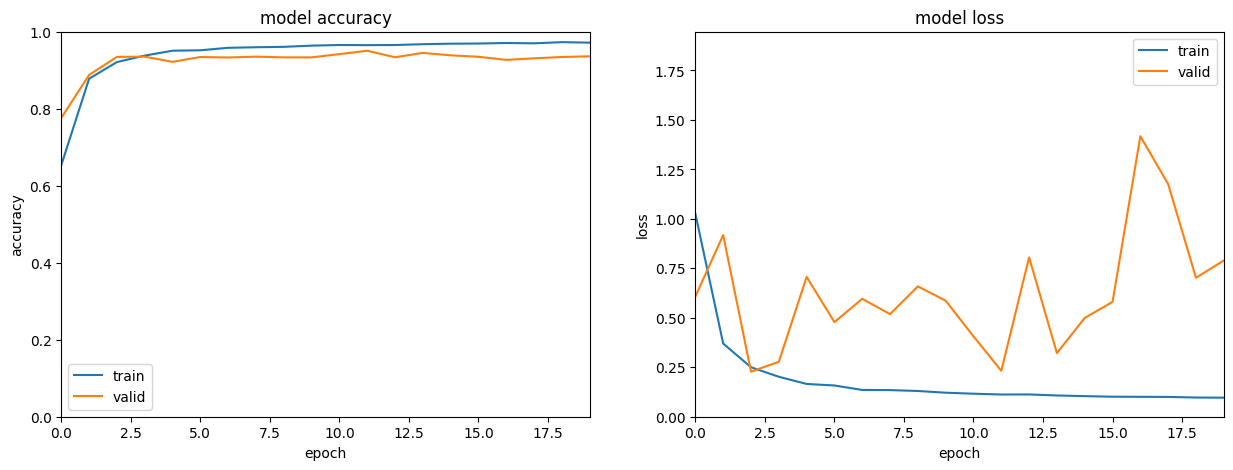

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

# plot training history for accuracy
ax[0].plot(logs['accuracy'], label='train')
ax[0].plot(logs['val_accuracy'], label='valid')
ax[0].set_title('model accuracy')
ax[0].set_ylim(0, 1)
ax[0].set_xlim(0, NUM_EPOCHS-1)
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(loc='best')

# plot training history for loss
ax[1].plot(logs['loss'], label='train')
ax[1].plot(logs['val_loss'], label='valid')
ax[1].set_title('model loss')
ax[1].set_ylim(0, -math.log(1/NUM_CLASSES))
ax[1].set_xlim(0, NUM_EPOCHS-1)
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(loc='best')

fig.savefig(f'{MODEL_DIR}/training_history.png', dpi=100, format="png")
plt.show()

## 3.4 Model Evaluation

The model evaluation will now check which classification quality our trained model achieves on unseen test data.

### Test Dataset

For simplicity, the validation data is used as test data in the following. __Important!__ This procedure is not optimal because our validation data is no longer independent due to parameter adjustments of the learning rate or similar and theoretically an overfitting on the validation data can occur. 
To ensure that the evaluation of the classification performance of the model remains meaningful, a small subset of the dataset should be retained as independent test data prior to model training and parameter tuning. 

Loading and preprocessing of the test data is done in the same way as in Section 2.

In [16]:
# test data pre-processing pipeline
test_transforms = transforms.Compose([
                        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])

# ImageFolder will read images found in subfolers of '/valid' and creates mini batches using the DataLoader
test_dataset = ImageFolder(root=VALID_DATA_DIR, transform=test_transforms)
test_loader = DataLoader(dataset=valid_dataset, 
                          shuffle=True, # shuffle only for visualization purposes else set to False 
                          batch_size=BATCH_SIZE, 
                          num_workers=4, # for multiprocessing
                          pin_memory=True)
print(f'Found {len(test_dataset.samples)} test images belonging to {len(test_dataset.classes)} classes: {test_dataset.classes}')

Found 3197 test images belonging to 7 classes: ['XR_ELBOW', 'XR_FINGER', 'XR_FOREARM', 'XR_HAND', 'XR_HUMERUS', 'XR_SHOULDER', 'XR_WRIST']


### Inference

Inference is the process of using a trained model to make predictions for previously unseen data. During inference, images of the test data are presented to the model as input. Each neuron in the output layer of the model generates output activations for each class of the dataset for each input image. To interpret the activations of the model's output neurons, they are converted into prediction probabilities using softmax activation, so that the prediction probabilities of all classes sum up to 1. The largest prediction probability of a class is then used as the final model prediction for the input image. 

To subsequently determine the classification performance of the model, the ground truths of the input images and the corresponding model predictions are combined and metrics (Macro Accuracy, Macro F1-Score, Recall, Precision) are computed.

In [17]:
# test metrics for evaluating the classification performance of the model 
test_accuracy_metric = Accuracy(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)
test_f1_metric = F1Score(task="multiclass", num_classes=NUM_CLASSES, average="macro").to(device)
test_recall_metric = Recall(task="multiclass", num_classes=NUM_CLASSES, average=None).to(device)
test_precision_metric = Precision(task="multiclass", num_classes=NUM_CLASSES, average=None).to(device)
confusion_matrix_metric = ConfusionMatrix(task="multiclass", num_classes=NUM_CLASSES, normalize=None, threshold=0.5).to(device)

# iterate over testdata batches (tqdm only for progress bar)
for (images, labels) in tqdm.tqdm(test_loader):
    # transfer images to the GPU for model inference
    images, labels = images.to(device), labels.to(device) 

    # model inference for each image in the batch 
    outputs = model(images) 
    prediction_probabilities = outputs.softmax(dim=-1) # compute the model prediction probabilities from logit outputs for all classes
    predictions = torch.argmax(prediction_probabilities, dim=-1) # get the class with the highest prediction probability for each image
    
    # update running test metrics
    test_accuracy_metric.update(predictions, labels)
    test_f1_metric.update(predictions, labels)
    test_recall_metric.update(predictions, labels)
    test_precision_metric.update(predictions, labels)
    confusion_matrix_metric.update(predictions, labels)
    
# calculate test metric results
test_accuracy = test_accuracy_metric.compute().detach().cpu().item()
test_f1 = test_f1_metric.compute().detach().cpu().item()
test_recall = test_recall_metric.compute().detach().cpu().numpy()
test_precision = test_precision_metric.compute().detach().cpu().numpy()
test_confusion_matrix = confusion_matrix_metric.compute().detach().cpu().numpy()

print(f"Testdata evaluation results:\nmacro Accuracy: {test_accuracy:.5f}\nmacro F1-Score: {test_f1:.5f}\n{pd.DataFrame({'Recall': test_recall, 'Precision': test_precision}, index = CLASSES)}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 31.95it/s]

Testdata evaluation results:
macro Accuracy: 0.92521
macro F1-Score: 0.93229
               Recall  Precision
XR_ELBOW     0.911828   0.961451
XR_FINGER    0.941432   0.966592
XR_FOREARM   0.833887   0.933086
XR_HAND      0.969565   0.936975
XR_HUMERUS   0.878472   0.965649
XR_SHOULDER  0.982238   0.937288
XR_WRIST     0.959029   0.890141


### Confusion Matrix
A [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) is helpful for interpreting the classification performance of the model. It can be used to determine which classes of the data set are frequently classified correctly or incorrectly by the model as well as which classes are most frequently confused.

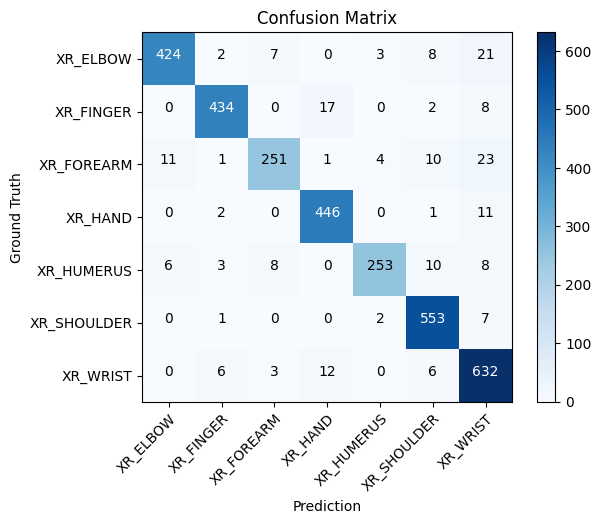

In [18]:
# confusion matrix computed earlier
cm = test_confusion_matrix
#print(f"confusion matrix:\n{cm}")

# plot confusion matrix
fig, ax = plt.subplots(1,1)
cm_fig = ax.imshow(cm, interpolation='nearest', cmap="Blues") # plot confusion matrix background color 
fig.colorbar(cm_fig, ax=ax) # add confusion matrix color bar
ax.set_xticks(np.arange(len(CLASSES)))
ax.set_yticks(np.arange(len(CLASSES)))
ax.set_xticklabels(CLASSES, rotation=45, ha='right', rotation_mode='anchor')
ax.set_yticklabels(CLASSES)
ax.set_xlabel('Prediction')
ax.set_ylabel('Ground Truth') 
ax.set_title("Confusion Matrix")

# plot confusion matrix values
for ix, iy in np.ndindex(cm.shape):
    ax.text(iy, ix, cm[ix, iy], horizontalalignment="center", color="white" if cm[ix, iy] > cm.max() / 2.0 else "black")    

fig.savefig(f'{MODEL_DIR}/confusion_matrix.png', dpi=100, format="png")
plt.show()    

### Inference with Visualization

Next is inference for a minibatch of the test data, followed by visualization of the ground truths and model predictions for each image of the minibatch.

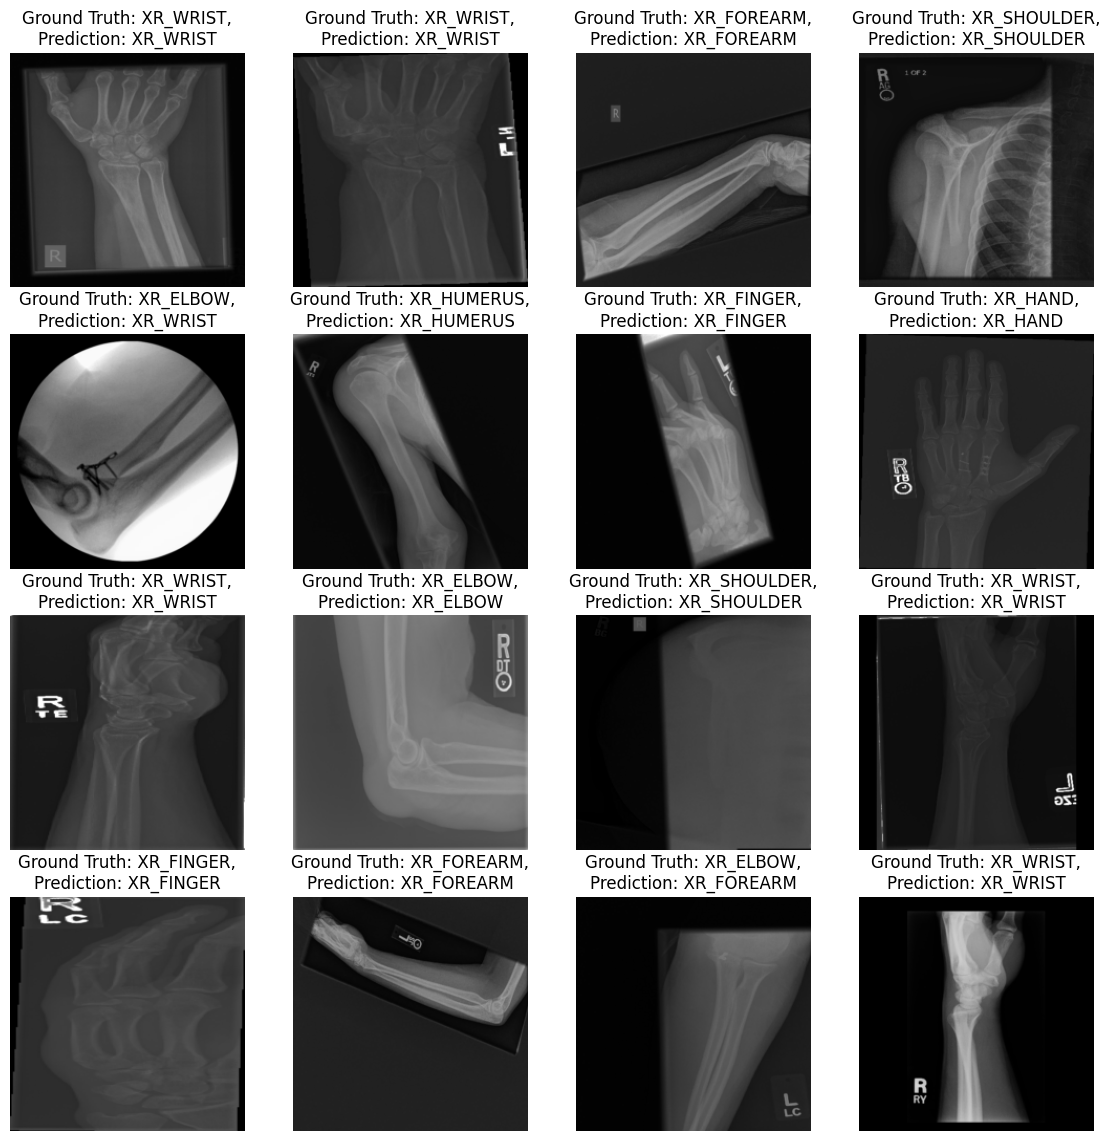

In [19]:
def denormalization(img, mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)):
    # denormalize pixel values of [-1,1] to [0,1] 
    img = img * std + mean 
    return img

def show_predictions(images, labels, predictions):
    images = images.cpu().numpy() 
    labels = labels.cpu().numpy()
    predictions = predictions.cpu().numpy()
    
    fig, ax = plt.subplots(4, 4, figsize=(14,14))
    for i, ax in enumerate(ax.flat):
        ax.imshow(denormalization(np.rollaxis(images[i,:,:,:],0,3)), vmin=0, vmax=1, cmap='gray') # np.rollaxis(images[i,:,:,:],0,3)) to swap channel axes to channels last
        ax.set_title(f"Ground Truth: {CLASSES[labels[i]]},\nPrediction: {CLASSES[predictions[i]]}")
        ax.axis('off')
    plt.show()

dataiter = iter(test_loader) # get iterator of test_loader 
images, labels = next(dataiter) # get a random batch of test_loader iterator 

# transfer images to the GPU for model inference
images, labels = images.to(device), labels.to(device) 

# model inference for each image in the batch 
outputs = model(images) 
prediction_probabilities = outputs.softmax(dim=-1) # compute the model prediction probabilities from logit outputs for all classes
predictions = torch.argmax(prediction_probabilities, dim=-1) # get the class with the highest prediction probability for each image

show_predictions(images, labels, predictions) # show model predictions

### GradCAM

GradCAM (Gradient-weighted Class Activation Mapping) is a method for visually explaining model prediction that uses the gradient information of any model layer to create a rough localization map of the image regions important for model prediction.

More details on GradCAM: https://arxiv.org/abs/1610.02391

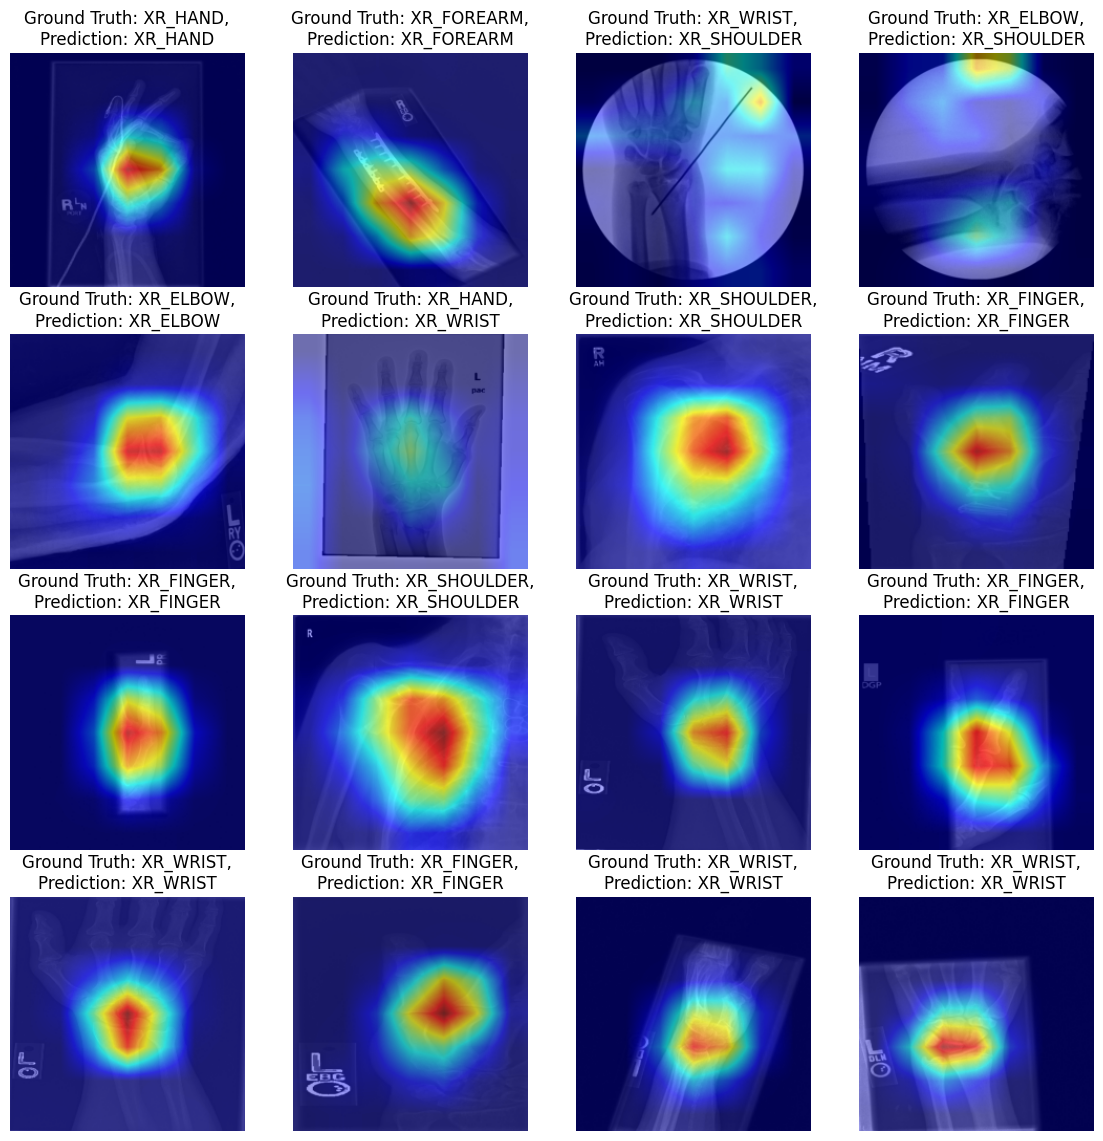

In [20]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

def denormalization(img, mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)):
    # denormalize pixel values of [-1,1] to [0,1] 
    img = img * std + mean 
    return img

def visualize_gradcam(images, gradcam_activations, labels, predictions):
    fig, ax = plt.subplots(4, 4, figsize=(14,14))
    for i, ax in enumerate(ax.flat):
        img = denormalization(np.rollaxis(images[i,:,:,:],0,3)) # denormalize image and swap channel axes to channels last
        image_gradcam_overlay = show_cam_on_image(img, gradcam_activations[i,:,:], use_rgb=True) # overlay image with GradCAM activation map
        
        ax.imshow(image_gradcam_overlay, cmap='gray') 
        ax.set_title(f"Ground Truth: {CLASSES[labels[i]]},\nPrediction: {CLASSES[predictions[i]]}")
        ax.axis('off')
    plt.show()
    
    
# get a random batch of test_loader iterator
dataiter = iter(test_loader)  
images, labels = next(dataiter) 
images = images.to(device) # transfer images to the GPU for model inference

# model inference, get predictions for each image in batch
outputs = model(images) 
prediction_probabilities = outputs.softmax(dim=-1) # compute the model prediction probability from logit outputs for all classes
predictions = torch.argmax(prediction_probabilities, dim=-1) # get the class with the highest prediction probability for each image

# get GradCAM for for each image in batch
# GradCAM must be able to calculate gradients for the model layers. Therefore, re-enable the gradients for all layers, since they were previously disabled during transfer learning.
for param in model.parameters():
    param.requires_grad = True 
gradcam_target_layers = [model.layer4[-1]] # choose the target layer to compute GradCAM
cam = GradCAM(model=model, target_layers=gradcam_target_layers) # multiple cams possible, see https://github.com/jacobgil/pytorch-grad-cam
gradcam_activations = cam(input_tensor=images, aug_smooth=True) # gradcam activation image (grayscale) 

visualize_gradcam(images.cpu().numpy(), gradcam_activations, labels, predictions.cpu().numpy())

### Out-Of-Class Images

To test how our model handles images and with classes it has never seen before, we now give it the following skull CT image:

<img src="https://prod-images-static.radiopaedia.org/images/17058746/a60ee77e6b44da2d72a25cea08dfd2_big_gallery.jpeg" width="300"/>
Source: radiopaedia.org

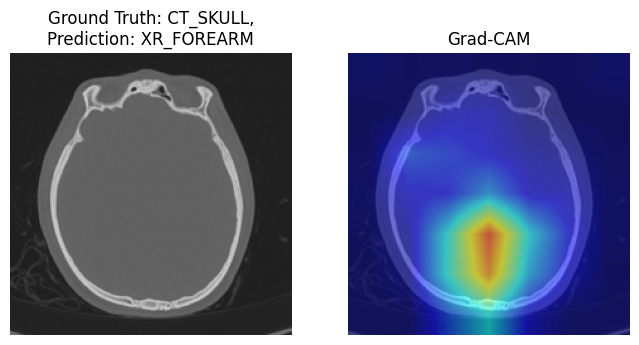

In [21]:
from PIL import Image
import requests

def denormalization(img, mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)):
    # denormalize pixel values of [-1,1] to [0,1] 
    img = img * std + mean 
    return img


image_url = "https://prod-images-static.radiopaedia.org/images/17058746/a60ee77e6b44da2d72a25cea08dfd2_big_gallery.jpeg"
image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB") # load image from URL
label = "CT_SKULL" # define image label 

image = test_transforms(image).unsqueeze(dim=0) # normalize pixel values [-1,1] using the previous defined test pre-processing pipeline and expand image dims to [1,C,H,W]
image = image.to(device) # move image to GPU-VRAM

# model inference for image
output = model(image) 
prediction_probability = output.softmax(dim=-1) # compute the model prediction probability from logit output for all classes
prediction = torch.argmax(prediction_probability, dim=-1) # get the class with the highest prediction probability for the image

# gradcam activation image (grayscale) (see previous cell)
gradcam_activation = cam(input_tensor=image, aug_smooth=True) 

# visualize model prediction
image = image.cpu().numpy()
image = denormalization(np.rollaxis(image[0,:,:,:],0,3)) # np.rollaxis(image[0,:,:,:],0,3)) to swap channel axes to channels last
prediction = prediction.cpu().item()

fig, ax = plt.subplots(1, 2, figsize=(8,8))
ax[0].imshow(image, vmin=0, vmax=1, cmap='gray') 
image_gradcam_overlay = show_cam_on_image(image, gradcam_activation[0,:,:], use_rgb=True) # overlay image with GradCAM activation map
ax[1].imshow(image_gradcam_overlay, cmap='gray') 
ax[0].set_title(f"Ground Truth: {label},\nPrediction: {CLASSES[prediction]}")
ax[1].set_title(f"Grad-CAM")
ax[0].axis('off')
ax[1].axis('off')
plt.show()